boudiing box can be represented in one of the following ways<br>
[x0, y0, w, h]<br>
[x0, y0, x1, y1]<br>
[xc, yc, w, h]<br>

### STEPS<br>
1. Exploratory data analysis
2. Data transformation for object detection
3. Creating custom datasets
4. Creating the model
5. Defining the loss, optimizer, and IOU metric
6. Training and evaluation of the model
7. Deploying the model

#### exploratory data analysis 

performed to understand characteristics of the data. we will inspect our dataset and visualize samples or statistical features of our data using boxplots, histograms, and other visualization tools. For instance, for tabular data, we would like to see the columns, a few rows, a number of records, and statistical metrics, such as the mean and standard deviation of our data. For imaging data, we would display sample images, labels, or bounding boxes of the objects in the images.

note: in this notebook we are only interested in localization otherwise object detection also involves classification and segmentation 

dataset link: https://refuge.grand-challenge.org/iChallenge-AMD/

In [1]:
!ls ../datasets/c4-pytorch-ssd-amd-iChallenge/Training400

AMD  Fovea_location.xlsx  Non-AMD


#### importing libraries 

In [2]:
import os
import pandas as pd

path2data="../datasets/c4-pytorch-ssd-amd-iChallenge/"

path2labels=os.path.join(path2data, "Training400", "Fovea_location.xlsx")

# make sure to install xlrd
labels_df = pd.read_excel(path2labels, index_col="ID")

labels_df.head()

,imgName,Fovea_X,Fovea_Y
ID,,,
1,A0001.jpg,1182.264278,1022.018842
2,A0002.jpg,967.754046,1016.946655
3,A0003.jpg,1220.206714,989.944033
4,A0004.jpg,1141.140888,1000.594955
5,A0005.jpg,1127.371832,1071.109440


In [3]:
labels_df.tail()

,imgName,Fovea_X,Fovea_Y
ID,,,
396,N0307.jpg,823.024991,690.210211
397,N0308.jpg,647.598978,795.653188
398,N0309.jpg,624.571803,755.694880
399,N0310.jpg,687.523044,830.449187
400,N0311.jpg,746.107631,759.623062


#### scatter plotting fovea X and Y coordinates

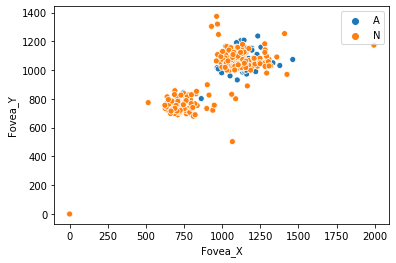

In [4]:
import seaborn as sns
%matplotlib inline

AorN=[imn[0] for imn in labels_df.imgName]
sns.scatterplot(x=labels_df['Fovea_X'], y=labels_df['Fovea_Y'],hue=AorN)

In [5]:
import numpy as np
from PIL import Image, ImageDraw
import matplotlib.pylab as plt

# fix random seed
np.random.seed(2019)

set plot parameters

In [6]:
plt.rcParams['figure.figsize'] = (15, 9)
plt.subplots_adjust(wspace=0, hspace=0.3)
nrows,ncols=2,3

<Figure size 1080x648 with 0 Axes>

select set of random images

In [7]:
imgName=labels_df["imgName"]
ids=labels_df.index
rndIds=np.random.choice(ids,nrows*ncols)
print(rndIds)

[ 73 371 160 294 217 191]


##### defining a helper function to load a single image and its label from local file

In [8]:
def load_img_label(labels_df,id_): 
    imgName=labels_df["imgName"] 
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    x=labels_df["Fovea_X"][id_]
    y=labels_df["Fovea_Y"][id_]
    label=(x,y)
    return img,label

##### now we define helper function to show the image and label as a bounding box 

In [9]:
def show_img_label(img,label,w_h=(50,50),thickness=2):   
    w,h=w_h                   
    cx,cy=label   
    draw = ImageDraw.Draw(img)
    draw.rectangle(((cx-w/2, cy-h/2), (cx+w/2, cy+h/2)),outline="green",width=thickness)
    plt.imshow(np.asarray(img))

### now show the random images with bounding boxes 

(2124, 2056) (1037.89889229694, 1115.71768088143)
(1444, 1444) (635.148992978281, 744.648850248249)
(1444, 1444) (639.360312038611, 814.762764100936)
(2124, 2056) (1122.08407442503, 1067.58829793991)
(2124, 2056) (1092.93333646222, 1055.15333296773)
(2124, 2056) (1112.50135915347, 1070.7251775623)


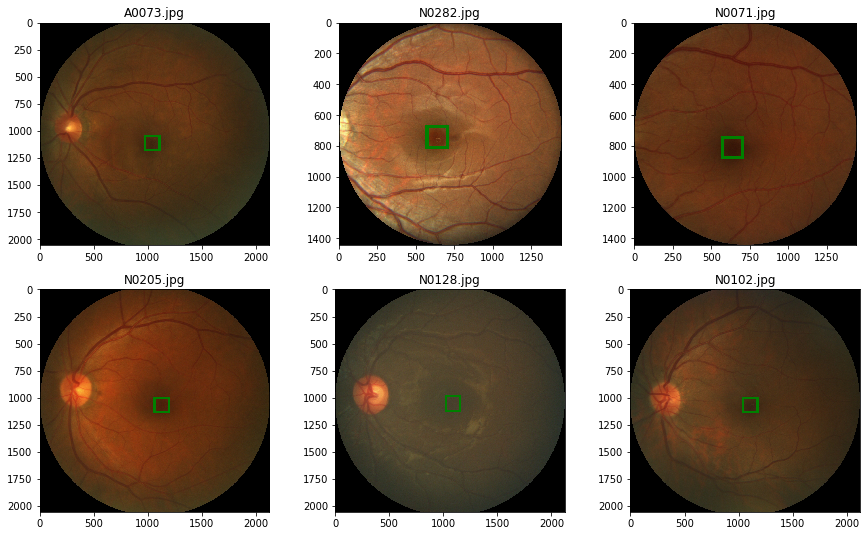

In [10]:
for i,id_ in enumerate(rndIds):
    img,label=load_img_label(labels_df,id_)   
    print(img.size,label)
    plt.subplot(nrows, ncols, i+1) 
    show_img_label(img,label,w_h=(150,150),thickness=20)
    plt.title(imgName[id_])

##### now collect image widhts and heights in two lists 

In [11]:
h_list,w_list=[],[]
for id_ in ids:
    if imgName[id_][0]=="A":
        prefix="AMD"
    else:
        prefix="Non-AMD"
    fullPath2img=os.path.join(path2data,"Training400",prefix,imgName[id_])
    img = Image.open(fullPath2img)
    h,w=img.size
    h_list.append(h)
    w_list.append(w)

##### now plot distributions of image heights 

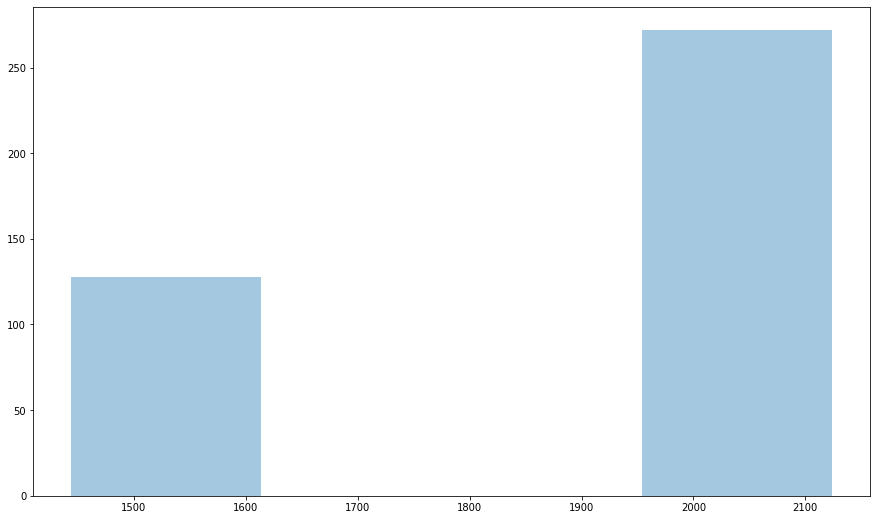

In [12]:
sns.distplot(a=h_list, kde=False)

##### now plot distribution of image widths 

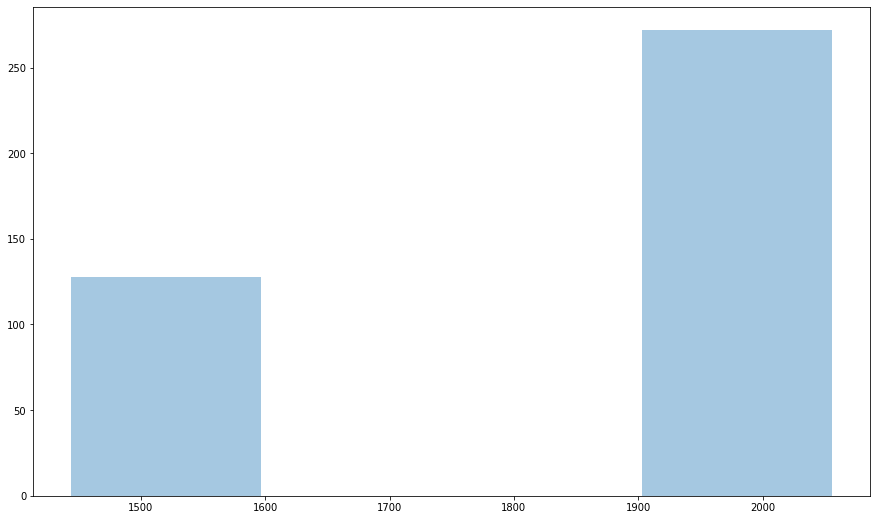

In [13]:
sns.distplot(a=w_list, kde=False)

## DATA TRANSFORMATION 

###  we will define a helper function for IMAGE RESIZING

In [14]:
import torchvision.transforms.functional as TF

def resize_img_label(image,label=(0.,0.),target_size=(256,256)):
    w_orig,h_orig = image.size   
    w_target,h_target = target_size
    cx, cy= label
    
    image_new = TF.resize(image,target_size)
    label_new= cx/w_orig*w_target, cy/h_orig*h_target
    
    return image_new,label_new

##### test image resizer 

(2124, 2056) (1182.26427759023, 1022.01884158854)
(256, 256) (142.4951295024006, 127.25526432230848)


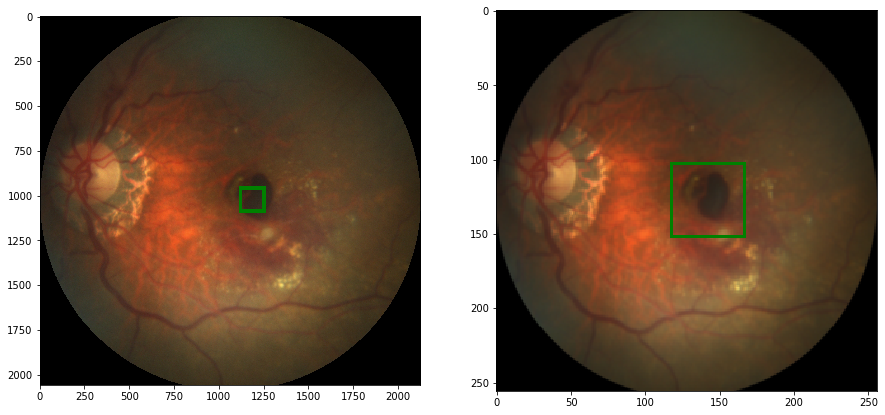

In [15]:
img, label=load_img_label(labels_df,1)   
print(img.size,label)

img_r,label_r=resize_img_label(img,label)
print(img_r.size,label_r)

plt.subplot(1,2,1)
show_img_label(img,label,w_h=(150,150),thickness=20)
plt.subplot(1,2,2)
show_img_label(img_r,label_r)

### we will define helper function for FLIPPING THE IMAGE HORIZONTALLY

In [16]:
def random_hflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.hflip(image)
    label = w-x, y
    return image, label

#### TESTING HORIZONTAL FLIP 

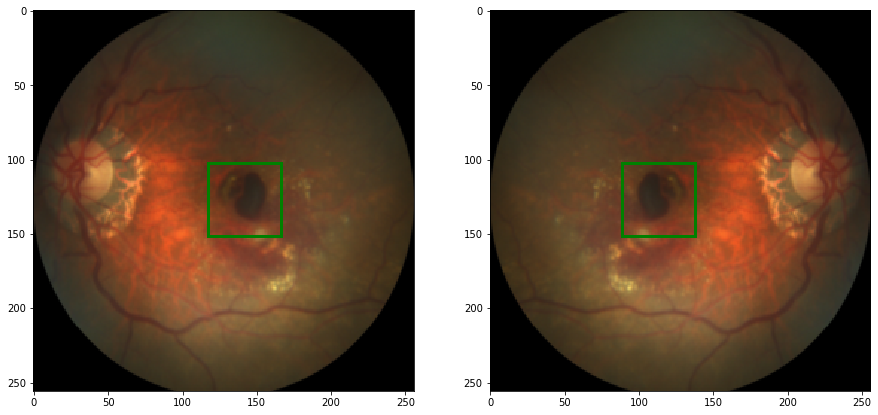

In [17]:
img, label = load_img_label(labels_df, 1)
img_r, label_r = resize_img_label(img, label)
img_fh, label_fh = random_hflip(img_r, label_r)

plt.subplot(1,2,1)
show_img_label(img_r, label_r)
plt.subplot(1,2,2)
show_img_label(img_fh, label_fh)

### we will define helper function for FLIPPING THE IMAGE VERTICALLY

In [18]:
def random_vflip(image, label):
    w,h = image.size
    x,y = label
    
    image = TF.vflip(image)
    label = x, w-y
    return image, label

#### TESTING VERTICAL FLIP

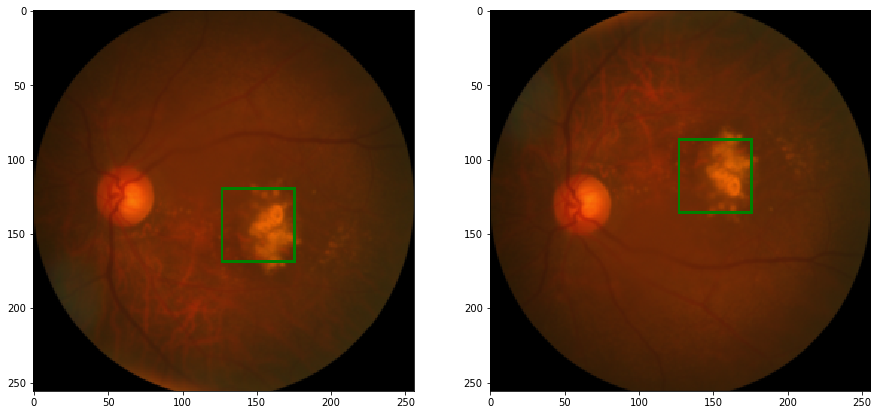

In [19]:
img, label = load_img_label(labels_df, 7)
img_r, label_r = resize_img_label(img, label)
img_fv, label_fv = random_vflip(img_r, label_r)

plt.subplot(1,2,1)
show_img_label(img_r, label_r)
plt.subplot(1,2,2)
show_img_label(img_fv, label_fv)

### Now we randomly define helper function to randomly shift or translate image in either direction  

In [ ]:
import numpy as np
np.random.seed(1)

def random_shift(image)